In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

#You can import other libraries if you want
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
cd 'drive/My Drive/AIP2'

/content/drive/My Drive/AIP2


In [4]:
###### DO NOT MODIFY THIS PART
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
######

In [5]:
artists = pd.read_csv('./train/artists.csv')
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 0].reset_index()
artists_top = artists_top[['name', 'paintings']]

# Create class weight since the data is imballanced
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)

updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

In [6]:
# Explore images of top artists
images_dir = './train/images' #Type Your Own Data Directory
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("find -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

find --> ./train/images/Vincent_van_Gogh
find --> ./train/images/Edgar_Degas
find --> ./train/images/Pablo_Picasso
find --> ./train/images/Pierre-Auguste_Renoir
find --> ./train/images/Albrecht_Dürer
find --> ./train/images/Paul_Gauguin
find --> ./train/images/Francisco_Goya
find --> ./train/images/Rembrandt
find --> ./train/images/Alfred_Sisley
find --> ./train/images/Titian
find --> ./train/images/Marc_Chagall


In [7]:
batch_size = 16 #Type your own batch size
input_shape = (224, 224, 3,) #Type your own input shape
n_classes = artists_top.shape[0]

# Class_weights -> dict to fit in the training.
class_weights = artists_top['class_weight'].to_dict()

#Image data generate with validation data fraction of 0.2, data rescale 1/255 and flip both ways.
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale = 1 / 255,
                                   shear_range = 5,
                                   horizontal_flip=True,
                                   vertical_flip=True)

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3092 images belonging to 11 classes.
Found 767 images belonging to 11 classes.
Total number of batches = 193 and 47


In [8]:
# Residual unit of Resnet50 according to the lecture.
class ResidualUnit50(Layer):
  def __init__(self, filters, strides = 1, activation = 'relu', is_first_layer = False, **kwargs):
    super().__init__(**kwargs)
    self.activation = tf.keras.activations.get(activation)
    # The first layer strides only 1 unit
    if is_first_layer:
      strides = 1
    # Add the main convolution layers of the residual unit
    self.main_layers = [Conv2D(filters, 1, strides = strides, kernel_initializer='he_normal'),
                        BatchNormalization(axis = 3),
                        self.activation,
                        Conv2D(filters, 3, padding = 'same', kernel_initializer='he_normal'),
                        BatchNormalization(axis = 3),
                        self.activation,
                        Conv2D(4 * filters, 1, kernel_initializer='he_normal'),
                        BatchNormalization(axis = 3)]
    # Add skip layers
    self.skip_layers = []
    if strides > 1 or is_first_layer:
      self.skip_layers = [Conv2D(4 * filters, 1, strides = strides, kernel_initializer='he_normal'),
                          BatchNormalization(axis = 3)]

  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [9]:
#######################
# Make your own model #
####################### 
model = Sequential()

# Input layers
model.add(InputLayer(input_shape = input_shape))

# Comvolution layers
model.add(ZeroPadding2D(padding = (3, 3)))
model.add(Conv2D(64, 7, strides = 2, padding = 'valid', kernel_initializer='he_normal'))
model.add(BatchNormalization(axis = 3))
model.add(Activation('relu'))
model.add(ZeroPadding2D(padding = (1, 1)))
model.add(MaxPool2D(pool_size = 3, strides = 2))

# Resnet50
prev_filters = 0
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit50(filters, strides = strides, is_first_layer = (prev_filters == 0)))
  prev_filters = filters

# Adding dense layers
model.add(Flatten())
model.add(Dense(512, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(64, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(n_classes, activation = 'softmax'))

optimizer = Adam(learning_rate = 0.0001)  

model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 230, 230, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit50 (ResidualUni (None, 56, 56, 256)       7

In [11]:
#training

n_epoch = 100 #Your Own Epoch num

# Reduce the learning rate by 0.1 if there aren't any improvements in the last 5 epochs
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 5, verbose = 1)

# Stop early if there aren't any improvements in the last 10 epochs
early_stop = EarlyStopping(monitor='val_loss', patience = 10, verbose=1, mode = 'auto', restore_best_weights = True)

history = model.fit_generator(generator = train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              class_weight = class_weights, 
                              shuffle = True, 
                              verbose=1, 
                              callbacks = [reduce_learning_rate, early_stop],
                              use_multiprocessing = True, 
                              workers = 16) #you can add kwargs if you want

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
193/193 [==============================] - 274s 1s/step - loss: 2.3424 - accuracy: 0.1928 - val_loss: 2.6774 - val_accuracy: 0.1051
Epoch 2/100
193/193 [==============================] - 136s 678ms/step - loss: 2.0356 - accuracy: 0.2773 - val_loss: 2.3107 - val_accuracy: 0.1835
Epoch 3/100
193/193 [==============================] - 122s 604ms/step - loss: 1.9052 - accuracy: 0.3056 - val_loss: 2.1867 - val_accuracy: 0.3152
Epoch 4/100
193/193 [==============================] - 123s 608ms/step - loss: 1.8282 - accuracy: 0.3231 - val_loss: 1.8933 - val_accuracy: 0.3657
Epoch 5/100
193/193 [==============================] - 123s 605ms/step - loss: 1.7914 - accuracy: 0.3381 - val_loss: 1.9631 - val_accuracy: 0.3590
Epoch 6/100
193/193 [==============================] - 123s 608ms/step - loss: 1.6966 - accuracy: 0.3664 - val_loss: 1.9808 - val_

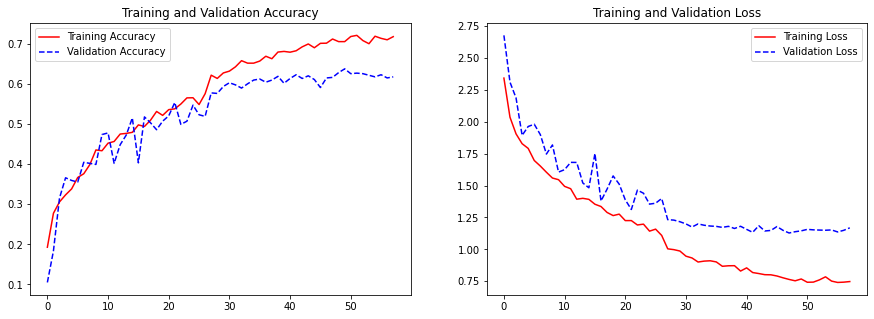

In [12]:
his = {}
his['loss'] = history.history['loss']
his['accuracy'] = history.history['accuracy'] 
his['val_loss'] = history.history['val_loss']
his['val_accuracy'] = history.history['val_accuracy']

# Plot the training graph
def plot_training(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(his)

In [13]:
model.save("MyModel_ver3")

INFO:tensorflow:Assets written to: MyModel_ver3/assets


INFO:tensorflow:Assets written to: MyModel_ver3/assets


In [15]:
output = model.evaluate(train_generator)
print("Training evaluation:", output)

194/194 [==============================] - 96s 496ms/step - loss: 0.6318 - accuracy: 0.8102
Training evaluation: [0.6317920088768005, 0.8101552128791809]


In [16]:
output = model.evaluate(valid_generator)
print("Validation evaluation:", output)

48/48 [==============================] - 24s 492ms/step - loss: 1.1515 - accuracy: 0.6258
Validation evaluation: [1.1515074968338013, 0.6258148550987244]
